# Using accelerometer data to identify activities

Charles Franzen

This [data set](http://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer#) consists of discrete samples of accelerometer data during various types of activities. This is a supervised learning classification task on time series data. I've used scikit-learn, scipy, numpy, and pandas as the core technologies of this analysis.

<!-- TEASER_END -->

From the README:

*The dataset collects data from a wearable accelerometer mounted on the chest. Uncalibrated Accelerometer Data are collected from 15 participants performing 7 activities. The dataset is intended for Activity Recognition research purposes. It provides challenges for identification and authentication of people using motion patterns.*

## Overview

The task that I've given myself is to identify the wearers of activity given a sample of accelerometer data. The general approach that I took was that of Casale and Radeva in their [paper](https://www.researchgate.net/publication/221258784_Human_Activity_Recognition_from_Accelerometer_Data_Using_at_Wearable_Device?ev=prf_pub) cited in the README that came with the data. The general approach involves dividing the dataset into sequential overlapping windows, then extracting features in the form of statistics from these smaller time-series. I didn't know much about signal processing prior to this project and I really enjoyed learning these techniques for time-series analysis.

In [1]:
# import libraries for matrix manipulation and data visualization

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The data set comes with uncalibrated data from 15 different participants in the study. I've decided to focus on just one of those participants.

In [2]:
# import data

data = pd.read_csv('activity_recognition/1.csv')

## Exploratory Analysis

In [3]:
data.head()

,0,1502,2215,2153,1
0,1,1667,2072,2047,1
1,2,1611,1957,1906,1
2,3,1601,1939,1831,1
3,4,1643,1965,1879,1
4,5,1604,1959,1921,1


In [4]:
# renaming columns
data.columns = ['sample', 'x', 'y', 'z', 'target']
data.head()

,sample,x,y,z,target
0,1,1667,2072,2047,1
1,2,1611,1957,1906,1
2,3,1601,1939,1831,1
3,4,1643,1965,1879,1
4,5,1604,1959,1921,1


In [5]:
# calculate and add norms for each data point
data['m'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

### Descriptive statistics

In [6]:
# check for missing data
nan_flag = False
for c in data.columns:
    if any(data[c] == np.nan):
        print c, 'contains NaNs'
        nan_flag = True
if not nan_flag:
    print 'No missing values.'

No missing values.


In [7]:
# examine class distribution
data['target'].value_counts()/float(len(data))

7    0.515372
1    0.207237
4    0.165292
3    0.068794
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: target, dtype: float64

### Visualizing the series

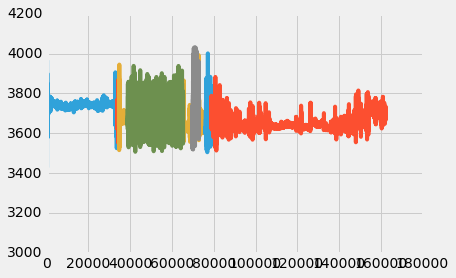

In [8]:
plt.style.use('fivethirtyeight')

for c in range(1, 8):
    plt.plot(data[data['target'] == c]['m'])

This gives an idea of the shape of the signal. It's clear that there are large differences between the different activities.

## Preprocessing

As recommended in the paper cited above, I generated two new time series from each of the original series plus the norms by applying digital filters. For each series I applied a high and low pass filter, with the cutoff set to 2hz, resulting in 12 total series.

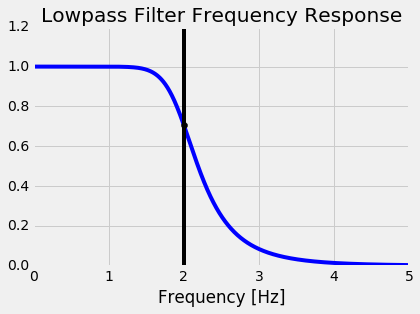

In [9]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    # helper function to return coefficients for scipy.lfilter
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    # applies a lowpass filter
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    # helper function to return coefficients for scipy.lfilter
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    # applies a highpass filter
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 52.0       # sample rate, Hz
cutoff = 2.     # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 5)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')

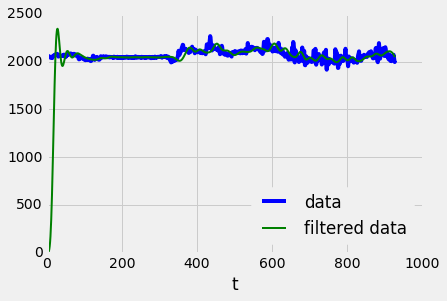

In [10]:
# test the filter on a sample of the dataset
filter_test_data = data[data['target'] == 2]['z']
filter_test_x = xrange(len(filter_test_data))
filter_test_y = butter_lowpass_filter(filter_test_data, cutoff, fs, order)
plt.plot(filter_test_x, filter_test_data, 'b-', label='data')
plt.plot(filter_test_x, filter_test_y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('t')
plt.legend(loc='lower right')

The filter behavior is a bit suspect at the left-tail. I've tested it on some constructed signals and it seems to work ok on them. My guess is that the filter must always start at the origin, so the fact that the data are not centered at zero causes this weird behavior at the beginning of the series.

In [11]:
# apply the filters
for c in ['x', 'y', 'z', 'm']:
    data[c+'l'] = butter_lowpass_filter(data[c], cutoff, fs, order)
    data[c+'h'] = butter_highpass_filter(data[c], cutoff, fs, order)

## Feature Extraction

I extracted features by windowing the series, creating 208 windows, each of a quarter second of data. Windows overlap adjacent windows, sharing 50% of its data with each. I extracted the following features from each window, for each time-series: root mean square value (RMS), mean of the minmax sums, mean, and standard deviation. This left me with 48 features.

### RMS

This is calculated by taking the square root of the average of the squares of the series.

### Minmax sums

This is calculated by finding the differences between each min and max in the series, then averaging these values.

In [12]:
from scipy.signal import argrelmin, argrelmax

def rms(series):
    # returns root mean square value of a series
    return np.sqrt((series**2).mean())


def min_max_mean(series):
    # returns the average of the differences between local mins/maxs
    mins = argrelmin(series)[0]    # indices of the local minima
    maxs = argrelmax(series)[0]    # local maxima
    min_max_sum = 0
    # build the sums, then take the average
    if len(mins) <= len(maxs):
        for j, arg in enumerate(mins):
            min_max_sum += series[maxs[j]] - series[arg]
    else:
        for j, arg in enumerate(maxs):
            min_max_sum += series[arg] - series[mins[j]]
    return min_max_sum/float(min(len(mins), len(maxs)))


def extract_features(data, y, num_windows):
    window_len = len(data)/(num_windows/2)
    i = 0    # initialize index
    features = []
    targets = []
    
    for n in range(num_windows):
        # isolate window
        win = data[i:i+window_len]
        
        # extract target
        target = int(y[i:i+window_len].mode())
        targets.append(target)
        
        for c in data.columns:
            # extract features for each series
            s = np.array(win[c])
            rms_val = rms(s)
            min_max = min_max_mean(s)
            mean = s.mean()
            std = s.std()
            new_features = [rms_val, min_max, mean, std]
            features.append(new_features)
        # update index
        i += window_len/2
    features = np.array(features)
    features.shape = num_windows, 48
    targets = np.array(targets)
    return features, targets

In [13]:
features = data.drop(['sample', 'target'], axis=1)
targets = data['target']

X, y = extract_features(features, targets, 208)

## Model building and evaluation

The null classifier predicts the majority class for every data point. I used this as a starting point.

In [14]:
from sklearn.cross_validation import train_test_split, cross_val_score

# train-test split
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = .3, random_state=1)

In [15]:
# majority class prediction
null = y_test.value_counts()[7] / float(len(y_test))
null

0.51476923076923076

In [16]:
import sklearn.metrics as met

# helper function to quickly build different models
def model_build(model):
    model.fit(X_train, y_train)
    return model

# helper function to handle evaluation
def model_eval(model):
    pred = model.predict(X_test)
    print 'Accuracy:\n-----------------------------'
    print met.accuracy_score(y_test, pred)
    print '\nConfusion Matrix:\n-----------------------------'
    print met.confusion_matrix(y_test, pred)
    print '\nClassification Report:\n-----------------------------'
    print met.classification_report(y_test, pred)

After testing numerous models and tuning parameters through [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV), K-nearest Neighbors and Random Forest came out on top in terms of classification accuracy. Models are blended using a simple voting classifier. One big issue with this data set is class imbalance. Smaller classes like class 2 and class 6 suffer from low recall. Class 3 indicates transitions between activites, which may be why it was classified less than perfectly.

## Evaluation Results

In [17]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = model_build(KNeighborsClassifier())
model_eval(knn)

Accuracy:
-----------------------------
0.914994871795

Confusion Matrix:
-----------------------------
[[10036     4     7    27     4     0    95]
 [   19   138     9    50     3     3    67]
 [    7    18  1761   203    26    25  1347]
 [   16    20    75  7600    39    31   167]
 [   10     5    18   192   674     1    89]
 [    4     2    55   550    15   193    50]
 [  105    29   607    97    25    28 24204]]

Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1       0.98      0.99      0.99     10173
          2       0.64      0.48      0.55       289
          3       0.70      0.52      0.60      3387
          4       0.87      0.96      0.91      7948
          5       0.86      0.68      0.76       989
          6       0.69      0.22      0.34       869
          7       0.93      0.96      0.95     25095

avg / total       0.91      0.91      0.91     48750



In [18]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = model_build(RandomForestClassifier(n_estimators=20))
model_eval(rfc)

Accuracy:
-----------------------------
0.923856410256

Confusion Matrix:
-----------------------------
[[10025     1     1    44     8     0    94]
 [    9    95     2    88     2     3    90]
 [    0     2  1814   229    23     8  1311]
 [    4     1    27  7734    54     9   119]
 [    5     5     3   223   653     0   100]
 [    5     0    29   613    20   139    63]
 [   83     3   242   163    16    10 24578]]

Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1       0.99      0.99      0.99     10173
          2       0.89      0.33      0.48       289
          3       0.86      0.54      0.66      3387
          4       0.85      0.97      0.91      7948
          5       0.84      0.66      0.74       989
          6       0.82      0.16      0.27       869
          7       0.93      0.98      0.96     25095

avg / total       0.92      0.92      0.91     48750



In [19]:
# Blending the models by voting
from sklearn.ensemble import VotingClassifier

vote = model_build(VotingClassifier(estimators=[('rf', rfc), ('knn', knn)]))
model_eval(vote)

Accuracy:
-----------------------------
0.917476923077

Confusion Matrix:
-----------------------------
[[10071     2     7    32     2     0    59]
 [   24   140     9    56     4     0    56]
 [    8    19  2112   192    19     9  1028]
 [   21    21    83  7716    20     4    83]
 [   13     5    21   256   624     0    70]
 [    8     3    65   638    16   108    31]
 [  134    30   728   188    29    30 23956]]

Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1       0.98      0.99      0.98     10173
          2       0.64      0.48      0.55       289
          3       0.70      0.62      0.66      3387
          4       0.85      0.97      0.91      7948
          5       0.87      0.63      0.73       989
          6       0.72      0.12      0.21       869
          7       0.95      0.95      0.95     25095

avg / total       0.91      0.92      0.91     48750



In [20]:
# Random Forest with weighted classes

rfc_bal = model_build(RandomForestClassifier(n_estimators=20, class_weight='balanced'))
model_eval(rfc_bal)

Accuracy:
-----------------------------
0.921394871795

Confusion Matrix:
-----------------------------
[[10016     2     1    47     6     1   100]
 [   14    84     0    85     2     0   104]
 [    1     2  1730   230    23    10  1391]
 [    5     1    23  7691    57     5   166]
 [    7     0     2   239   630     1   110]
 [    2     0    21   629    17   115    85]
 [   73     4   221   125    15     5 24652]]

Classification Report:
-----------------------------
             precision    recall  f1-score   support

          1       0.99      0.98      0.99     10173
          2       0.90      0.29      0.44       289
          3       0.87      0.51      0.64      3387
          4       0.85      0.97      0.91      7948
          5       0.84      0.64      0.72       989
          6       0.84      0.13      0.23       869
          7       0.93      0.98      0.95     25095

avg / total       0.92      0.92      0.91     48750



## Conclusions and next steps

This approach ended up being quite successfull: much better than the null(~51%), and better than attempting to classify the raw data (~85%, based upon an earlier attempt at this problem). My results were slightly worse than those in the paper that I used as my guide. They were getting around 94% accuracy, and mine is around 91%. However, they extracted almost 400 features and I acheived similar results with only 48. If needed, the next few percentage points could be squeezed out with some additional feature extraction.

The dataset is highly imbalanced, and there's generally not enough data for certain classes. Gathering additional training data in a more balanced fashion could greatly improve the models. The Casale and Redeva paper mentions microphone and video data as interesting features that could be captured and lead to better model performance. I think that microphone data in particular would be usefull in differentiating talking, walking, and being still.

Another interesting problem that could be investigated using this dataset is trying to identify a specific person given a sample of data.

## References

* Casale, P. Pujol, O. and Radeva, P. 
'Personalization and user verification in wearable systems using biometric walking patterns' 
Personal and Ubiquitous Computing, 16(5), 563-580, 2012

* Casale, P. Pujol, O. and Radeva, P. 
  "BeaStreamer-v0.1: a new platform for Multi-Sensors Data Acquisition in Wearable Computing Applications", 
   CVCRD09, ISBN: 978-84-937261-1-9, 2009
   available on https://www.researchgate.net/publication/257132489_BeaStreamer-v0.1_a_new_platform_for_Multi-Sensors_Data_Acquisition_in_Wearable_Computing_Applications?ev=prf_pub